# Desafio Técnico - Classificação

Importação de bibliotecas utilisadas na resolução dos problemas propostos:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from math import log
import numpy as np
from sklearn.model_selection import StratifiedKFold
import optuna

In [2]:
sns.set(color_codes=True)

Leitura de base de dados destinada a classificação:

In [3]:
df = pd.read_csv("data/classification_train.csv")
df.head()

,x1,x2,target
0,1.934224,-0.111822,1
1,1.767383,-0.976402,1
2,0.937101,-0.085633,1
3,1.340732,0.166960,1
4,-0.199901,-0.155204,1


Checagem das instâncias em relação a missing values:

In [4]:
counts = {col: [df[col].isnull().sum()] for col in df}
print(counts)
missing_values = pd.DataFrame.from_dict(counts, orient='index', columns=['Missing Values'])
missing_values

{'x1': [0], 'x2': [0], 'target': [0]}


,Missing Values
x1,0
x2,0
target,0


Nota-se a ausência de valores faltantes pela tabela acima.

Dimensões do dataset:

In [5]:
df.shape

(670, 3)

Observamos pelo resultado acima que estamos trabalhando com um dataset de 670 instâncias, cada uma com 3 atributos: x1, x2 e target, onde a última será nossa label para a classificação.

Destrinchando a coluna target:

In [6]:
df['target'].unique()

array([1, 0], dtype=int64)

Nota-se que se trata de um problema de classificação binária, uma vez, que a classe target é composta apenas por dois possíveis valores (0 ou 1)

A seguir vamos verificar a coluna target quanto ao seu balancemento, para o caso de precisarmos nos preocupar com esse problema (que no caso não será necessário):

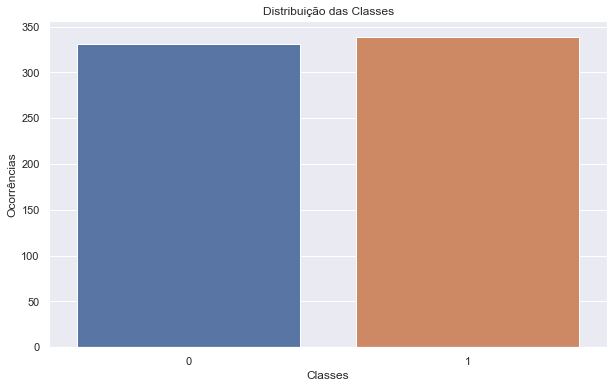

In [7]:
plt.figure(figsize=(10, 6))
plt.title('Distribuição das Classes')
plt.xlabel('Classes')
plt.ylabel('Ocorrências')
#plt.xticks(rotation=85)
sns.barplot(x=df['target'].unique(), y=[list(df['target']).count(i) for i in df['target'].unique()]);

In [8]:
att = ['x1', 'x2']

Por se tratar de um problema bidimensional pode-se facilmente plotar um gráfico com a distribuição das instâncias, como será feito a seguir:

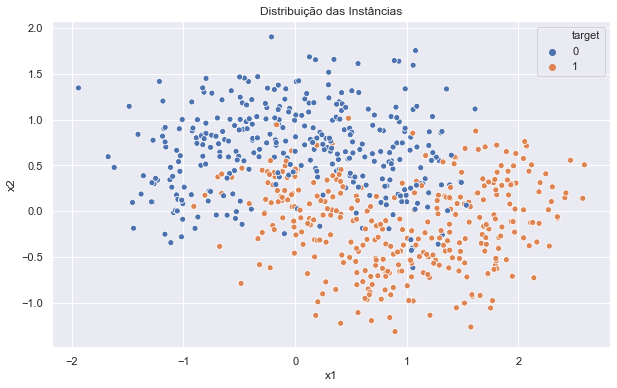

In [9]:
plt.figure(figsize=(10, 6))
plt.title('Distribuição das Instâncias')
plt.xlabel('X1')
plt.ylabel('X2')
sns.scatterplot(data=df, x="x1", y="x2", hue="target");

Perceba que os dados estão distribuídos em um intervalo bem contido com valores variando entre aproximadamente -2 e 2. Vamos aplicar uma normalização as intâncias apenas para "transportar" os dados para a origem, os distribuindo entre 0 e 1 nos dois eixos, note, que ao aplicarmos esse processo às instâncias, no gráfico abaixo a única mudança será nos eixos do gráfico.

In [10]:
normalized_df = df[['x1', 'x2']].copy()
normalized_df = (normalized_df-normalized_df.min())/(normalized_df.max()-normalized_df.min())
normalized_df['target'] = df['target']

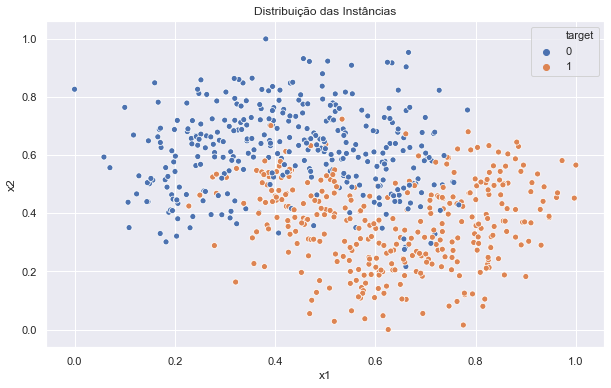

In [11]:
plt.figure(figsize=(10, 6))
plt.title('Distribuição das Instâncias')
plt.xlabel('X1')
plt.ylabel('X2')
sns.scatterplot(data=normalized_df, x="x1", y="x2", hue="target");

Antes de partirmos para os modelos de classificação vamos fazer uma breve exploração dos dados buscando alguma correlação entre as colunas, e especialmente entre as instâncias e a nossa label, afim de gerarmos algum insight para uma tomada de decisão.

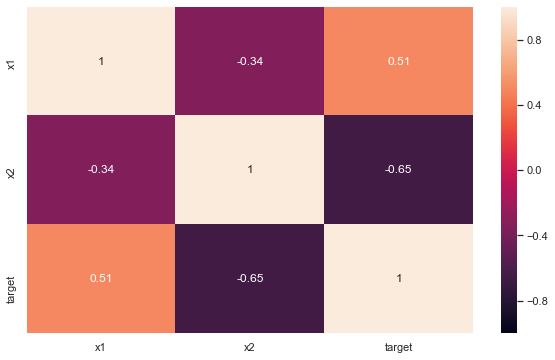

In [12]:
plt.figure(figsize=(10, 6))
corrMatrix = normalized_df.corr()
ax = sns.heatmap(corrMatrix, annot=True, vmin=-1,vmax=1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

Pode-se notar que há uma leve tendência positiva entre a label "target" e o atributo "x1", como podemos observar de forma intuitiva também pelo plot de distribuição das instãncias, já que os dados da classe 1, aparecem claramente mais a direita do que os da classe 0. De forma semelhante existe uma correlação (um pouco mais forte) negativa entre o "target" (classe 1) e a coluna "x2", também observável no gráfico, uma vez que as instâncias da classe 0 se encontram no geral mais acima no plot do que as instâncias da classe 1.

# Classificação:

Vamos explorar alguns diferentes modelos, em busca de um que melhor se adeque aos nossos dados, mas para avaliarmos cada um será feito uso do k-fold cross validation, com k=10, e fazendo uso das seguintes métricas: Acurácia, Precision, Recall, F1 Score e F2 Score.

In [13]:
def skfold(X, y, model):
    r = {}
    acc = []
    rec = []
    prec = []
    f1l = []
    f2l = []
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    skf.get_n_splits(X, y)
    for train_index, val_index in skf.split(X, y):
        #print(train_index)
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        acc.append(accuracy_score(y_val, y_pred))
        rec.append(recall_score(y_val, y_pred))
        prec.append(precision_score(y_val, y_pred))
        f1l.append(f1_score(y_val, y_pred))
        f2l.append(fbeta_score(y_val, y_pred, beta=2))
        
    r['accuracy'] = sum(acc)/len(acc) 
    r['recall'] = sum(rec)/len(rec)
    r['precision'] = sum(prec)/len(prec)
    r['f1_score'] = sum(f1l)/len(f1l)
    r['f2_score'] = sum(f2l)/len(f2l)
    
    model.fit(X, y)
    
    return (r, model)

In [14]:
results = {}
models = {}

Para comparação futura, vamos guardar em um dicionário todas as métricas obtidas por cada modelo de classificação, assim como o próprio modelo em si já treinado em um dicionário a parte.

In [15]:
clf = LogisticRegression()
results['Logistic Regression'], models['Logistic Regression'] = skfold(normalized_df[att], normalized_df['target'], clf)
results

{'Logistic Regression': {'accuracy': 0.8373134328358208,
  'recall': 0.8319964349376112,
  'precision': 0.8456740113414195,
  'f1_score': 0.8374355308724397,
  'f2_score': 0.8338556368784497}}

In [16]:
models

{'Logistic Regression': LogisticRegression()}

Uma breve interpretação da Regressão Logística pode ser feita a partir do gráfico abaixo, a reta gerada a partir do modelo nos dá uma boa ideia de que o problema que estamos trabalhando não é linearmente separado, o que nos fará recorrer a outros tipos de classificadores, como Decision Tree, Random Forest, MLP e knn. Nota-se todavia, assim como podemos inferir pela matriz de confusão gerada acima, que os atributos x1 e x2 tem coeficientes, respectivamente positivos e negativos sobre a função da reta.

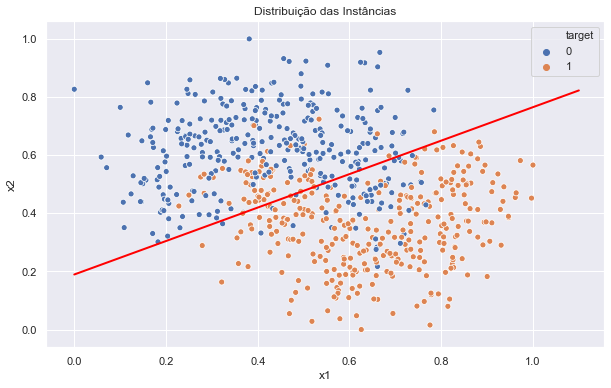

In [17]:
coef = models['Logistic Regression'].coef_
intercept = models['Logistic Regression'].intercept_

x1 = np.linspace(0, 1.1, 100)
x2 = -(x1*(coef[0][0]/coef[0][1])) - ((intercept[0]/coef[0][1]))
plt.figure(figsize=(10, 6))
plt.title('Distribuição das Instâncias')
plt.xlabel('X1')
plt.ylabel('X2')
sns.scatterplot(data=normalized_df, x="x1", y="x2", hue="target");
plt.plot(x1, x2, color='red', linewidth=2);

Em ordem coeficientes de x1 e x2:

In [18]:
coef

array([[ 3.97101396, -6.89749406]])

Executando MLP com 10-fold, guardando métricas e modelo treinado:

In [19]:
clf = MLPClassifier(random_state=0, max_iter=300)
results['MLP'], models['MLP'] = skfold(normalized_df[att], normalized_df['target'], clf)
results

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'Logistic Regression': {'accuracy': 0.8373134328358208,
  'recall': 0.8319964349376112,
  'precision': 0.8456740113414195,
  'f1_score': 0.8374355308724397,
  'f2_score': 0.8338556368784497},
 'MLP': {'accuracy': 0.8373134328358208,
  'recall': 0.8437611408199643,
  'precision': 0.8377439227439227,
  'f1_score': 0.8392193229213797,
  'f2_score': 0.8415869062545056}}

In [20]:
"""for i in range(20):
    classifier_obj = DecisionTreeClassifier(random_state=0, max_depth=max_deep, min_samples_split=min_samples)"""

'for i in range(20):\n    classifier_obj = DecisionTreeClassifier(random_state=0, max_depth=max_deep, min_samples_split=min_samples)'

Para os modelos de Decision Tree e Random forest faremos uma breve busca por melhores hiperparâmetros, usando a biblioteca Optuna, usaremos como valor a a ser maximizado a métrica F1, mas poderia facilmente ser trocada por alguma outra julgada mais crucial para o problema, vamos variar os valores de profundidade das árvores geradas, bem como o número mínimo de instâncias em um nó para que ele possa ser subdividido.

In [21]:
# Define an objective function to be minimized.
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    regressor_name = trial.suggest_categorical('classifier', ['DecisionTree'])
    if regressor_name == 'DecisionTree':
        min_samples = trial.suggest_int('min_samples', 2, int(df.shape[0]/2))
        max_deep = trial.suggest_int('max_deep', 1, 30)
        classifier_obj = DecisionTreeClassifier(random_state=0, max_depth=max_deep, min_samples_split=min_samples)
    
    
    f1 = skfold(normalized_df[att], normalized_df['target'], classifier_obj)[0]['f1_score']

    return f1  # An objective value linked with the Trial object.

study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.

[I 2021-04-09 15:19:43,569] A new study created in memory with name: no-name-3499a17a-164c-45a1-bfa1-b2cac274ab01
[I 2021-04-09 15:19:43,815] Trial 0 finished with value: 0.8598212211274143 and parameters: {'classifier': 'DecisionTree', 'min_samples': 226, 'max_deep': 2}. Best is trial 0 with value: 0.8598212211274143.
[I 2021-04-09 15:19:44,051] Trial 1 finished with value: 0.8628022042387574 and parameters: {'classifier': 'DecisionTree', 'min_samples': 56, 'max_deep': 21}. Best is trial 1 with value: 0.8628022042387574.
[I 2021-04-09 15:19:44,307] Trial 2 finished with value: 0.8480088741327556 and parameters: {'classifier': 'DecisionTree', 'min_samples': 26, 'max_deep': 20}. Best is trial 1 with value: 0.8628022042387574.
[I 2021-04-09 15:19:44,559] Trial 3 finished with value: 0.8614534210526819 and parameters: {'classifier': 'DecisionTree', 'min_samples': 21, 'max_deep': 6}. Best is trial 1 with value: 0.8628022042387574.
[I 2021-04-09 15:19:44,818] Trial 4 finished with value: 0.

[I 2021-04-09 15:19:57,054] Trial 37 finished with value: 0.8714327968717317 and parameters: {'classifier': 'DecisionTree', 'min_samples': 202, 'max_deep': 9}. Best is trial 5 with value: 0.8714327968717317.
[I 2021-04-09 15:19:57,346] Trial 38 finished with value: 0.8465606024473222 and parameters: {'classifier': 'DecisionTree', 'min_samples': 258, 'max_deep': 7}. Best is trial 5 with value: 0.8714327968717317.
[I 2021-04-09 15:19:57,687] Trial 39 finished with value: 0.8284528804445624 and parameters: {'classifier': 'DecisionTree', 'min_samples': 7, 'max_deep': 9}. Best is trial 5 with value: 0.8714327968717317.
[I 2021-04-09 15:19:57,930] Trial 40 finished with value: 0.8465606024473222 and parameters: {'classifier': 'DecisionTree', 'min_samples': 286, 'max_deep': 14}. Best is trial 5 with value: 0.8714327968717317.
[I 2021-04-09 15:19:58,187] Trial 41 finished with value: 0.8714327968717317 and parameters: {'classifier': 'DecisionTree', 'min_samples': 183, 'max_deep': 30}. Best is 

[I 2021-04-09 15:20:09,635] Trial 74 finished with value: 0.8714327968717317 and parameters: {'classifier': 'DecisionTree', 'min_samples': 179, 'max_deep': 17}. Best is trial 61 with value: 0.8750707278455859.
[I 2021-04-09 15:20:09,893] Trial 75 finished with value: 0.8714327968717317 and parameters: {'classifier': 'DecisionTree', 'min_samples': 202, 'max_deep': 13}. Best is trial 61 with value: 0.8750707278455859.
[I 2021-04-09 15:20:10,160] Trial 76 finished with value: 0.8714327968717317 and parameters: {'classifier': 'DecisionTree', 'min_samples': 181, 'max_deep': 15}. Best is trial 61 with value: 0.8750707278455859.
[I 2021-04-09 15:20:10,414] Trial 77 finished with value: 0.8714327968717317 and parameters: {'classifier': 'DecisionTree', 'min_samples': 191, 'max_deep': 19}. Best is trial 61 with value: 0.8750707278455859.
[I 2021-04-09 15:20:10,668] Trial 78 finished with value: 0.863351822017318 and parameters: {'classifier': 'DecisionTree', 'min_samples': 117, 'max_deep': 21}. 

In [22]:
# max_depth=16, min_samples_split=128 -> f1 = 87.6

Guardando as métricas obtidas e o melhor modelo encontrado na busca:

In [23]:
clf = DecisionTreeClassifier(random_state=0, max_depth=16, min_samples_split=128)
results['Decision Tree'], models['Decision Tree'] = skfold(normalized_df[att], normalized_df['target'], clf)
results

{'Logistic Regression': {'accuracy': 0.8373134328358208,
  'recall': 0.8319964349376112,
  'precision': 0.8456740113414195,
  'f1_score': 0.8374355308724397,
  'f2_score': 0.8338556368784497},
 'MLP': {'accuracy': 0.8373134328358208,
  'recall': 0.8437611408199643,
  'precision': 0.8377439227439227,
  'f1_score': 0.8392193229213797,
  'f2_score': 0.8415869062545056},
 'Decision Tree': {'accuracy': 0.8656716417910448,
  'recall': 0.9350267379679144,
  'precision': 0.8247929043594677,
  'f1_score': 0.8760535288283868,
  'f2_score': 0.9103975654006753}}

Uma vantagem do uso de árvores é que o modelo nos possibilita uma visualização gráfica do processo de tomada de decisão, bem como um grau de mais ou menos segurança para cada folha, o que pode ser de grande utilidade se pretendemos usá-lo como um suporte para tomada de decisão.

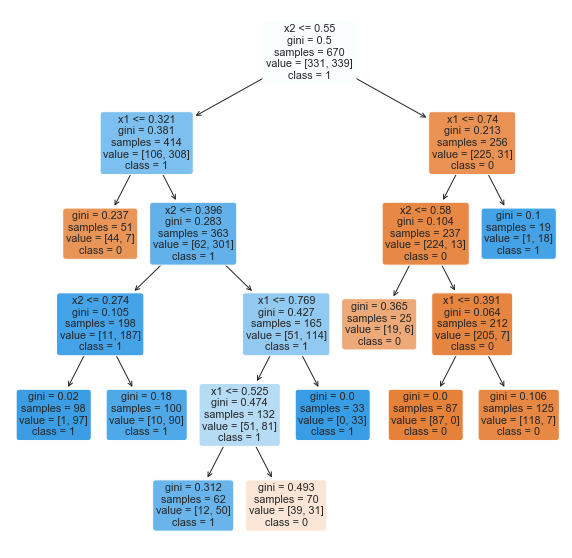

In [24]:
from sklearn import tree
plt.figure(figsize=(10, 10))
tree.plot_tree(models['Decision Tree'], feature_names=['x1', 'x2'], class_names=['0', '1'], filled=True, rounded=True);

Similarmente a Decision Tree buscaremos encontrar o melhor conjunto de parâmetros para uma random forest, variaremos os mesmos parâmetros que na Decision Tree com o acrescimo do número de árvores geradas.

In [25]:
# Define an objective function to be minimized.
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    regressor_name = trial.suggest_categorical('classifier', ['RandomForest'])
    if regressor_name == 'RandomForest':
        n = trial.suggest_int('n_trees', 10, 100)
        min_samples = trial.suggest_int('min_samples', 2, int(df.shape[0]/2))
        max_deep = trial.suggest_int('max_deep', 1, 30)
        classifier_obj = RandomForestClassifier(n_estimators=n, random_state=0, max_depth=max_deep, min_samples_split=min_samples)
    
    
    f1 = skfold(normalized_df[att], normalized_df['target'], classifier_obj)[0]['f1_score']

    return f1  # An objective value linked with the Trial object.

study = optuna.create_study(direction='maximize')  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.

[I 2021-04-09 15:20:18,657] A new study created in memory with name: no-name-bb737d9a-7d80-4ef7-bf93-3e4d4254e53c
[I 2021-04-09 15:20:22,810] Trial 0 finished with value: 0.8771393256591915 and parameters: {'classifier': 'RandomForest', 'n_trees': 99, 'min_samples': 51, 'max_deep': 6}. Best is trial 0 with value: 0.8771393256591915.
[I 2021-04-09 15:20:24,577] Trial 1 finished with value: 0.8478028307902198 and parameters: {'classifier': 'RandomForest', 'n_trees': 39, 'min_samples': 200, 'max_deep': 19}. Best is trial 0 with value: 0.8771393256591915.
[I 2021-04-09 15:20:26,140] Trial 2 finished with value: 0.8465605947653752 and parameters: {'classifier': 'RandomForest', 'n_trees': 34, 'min_samples': 186, 'max_deep': 22}. Best is trial 0 with value: 0.8771393256591915.
[I 2021-04-09 15:20:27,965] Trial 3 finished with value: 0.8450112211059062 and parameters: {'classifier': 'RandomForest', 'n_trees': 39, 'min_samples': 315, 'max_deep': 26}. Best is trial 0 with value: 0.87713932565919

[I 2021-04-09 15:22:06,668] Trial 35 finished with value: 0.8901256060487066 and parameters: {'classifier': 'RandomForest', 'n_trees': 35, 'min_samples': 21, 'max_deep': 10}. Best is trial 32 with value: 0.8918688043950531.
[I 2021-04-09 15:22:09,095] Trial 36 finished with value: 0.8766232939760549 and parameters: {'classifier': 'RandomForest', 'n_trees': 30, 'min_samples': 48, 'max_deep': 19}. Best is trial 32 with value: 0.8918688043950531.
[I 2021-04-09 15:22:11,675] Trial 37 finished with value: 0.8676841321957802 and parameters: {'classifier': 'RandomForest', 'n_trees': 32, 'min_samples': 77, 'max_deep': 14}. Best is trial 32 with value: 0.8918688043950531.
[I 2021-04-09 15:22:13,748] Trial 38 finished with value: 0.8876062297999978 and parameters: {'classifier': 'RandomForest', 'n_trees': 40, 'min_samples': 20, 'max_deep': 17}. Best is trial 32 with value: 0.8918688043950531.
[I 2021-04-09 15:22:14,886] Trial 39 finished with value: 0.8510396900290995 and parameters: {'classifie

[I 2021-04-09 15:23:18,441] Trial 70 finished with value: 0.8918843026642638 and parameters: {'classifier': 'RandomForest', 'n_trees': 47, 'min_samples': 26, 'max_deep': 15}. Best is trial 41 with value: 0.893615071895033.
[I 2021-04-09 15:23:20,332] Trial 71 finished with value: 0.8918843026642638 and parameters: {'classifier': 'RandomForest', 'n_trees': 47, 'min_samples': 26, 'max_deep': 15}. Best is trial 41 with value: 0.893615071895033.
[I 2021-04-09 15:23:22,354] Trial 72 finished with value: 0.8752756161588913 and parameters: {'classifier': 'RandomForest', 'n_trees': 46, 'min_samples': 41, 'max_deep': 16}. Best is trial 41 with value: 0.893615071895033.
[I 2021-04-09 15:23:23,850] Trial 73 finished with value: 0.8911402844853293 and parameters: {'classifier': 'RandomForest', 'n_trees': 35, 'min_samples': 12, 'max_deep': 18}. Best is trial 41 with value: 0.893615071895033.
[I 2021-04-09 15:23:25,980] Trial 74 finished with value: 0.8780072234615439 and parameters: {'classifier': 

In [26]:
# n_trees = 49, min_samples = 23, max_deep = 16 -> 0.893615071895033

In [27]:
clf = RandomForestClassifier(n_estimators = 49, random_state=0, max_depth=16, min_samples_split=23)
results['Random Forest'], models['Random Forest'] = skfold(normalized_df[att], normalized_df['target'], clf)
results

{'Logistic Regression': {'accuracy': 0.8373134328358208,
  'recall': 0.8319964349376112,
  'precision': 0.8456740113414195,
  'f1_score': 0.8374355308724397,
  'f2_score': 0.8338556368784497},
 'MLP': {'accuracy': 0.8373134328358208,
  'recall': 0.8437611408199643,
  'precision': 0.8377439227439227,
  'f1_score': 0.8392193229213797,
  'f2_score': 0.8415869062545056},
 'Decision Tree': {'accuracy': 0.8656716417910448,
  'recall': 0.9350267379679144,
  'precision': 0.8247929043594677,
  'f1_score': 0.8760535288283868,
  'f2_score': 0.9103975654006753},
 'Random Forest': {'accuracy': 0.891044776119403,
  'recall': 0.9026737967914439,
  'precision': 0.8863865063416274,
  'f1_score': 0.893615071895033,
  'f2_score': 0.8988231703974066}}

Por fim vamos ainda rodar o Knn sobre nossa base de dados, variando o valor de K entre 1 e 29, para guardarmos o melhor resultado e modelo obtido.

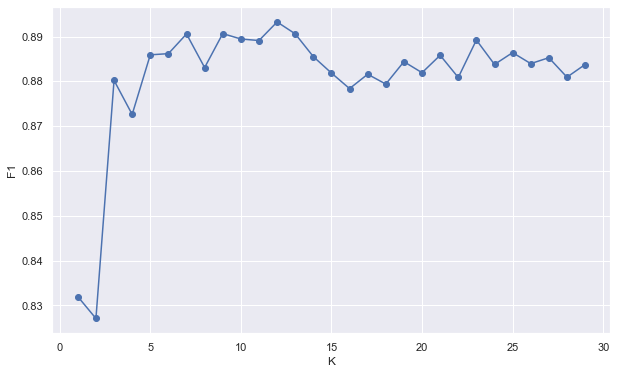

In [28]:
f1s = []
for k in range(1, 30):
    clf = KNeighborsClassifier(n_neighbors=k)
    f1s.append(skfold(normalized_df[att], normalized_df['target'], clf)[0]['f1_score'])
    
x = list(range(1,30))
y = f1s
plt.figure(figsize=(10,6))
plt.xlabel('K')
plt.ylabel('F1')
plt.plot(x,y,marker='o');

In [29]:
clf = KNeighborsClassifier(n_neighbors=12)
results['KNN'], models['KNN'] = skfold(normalized_df[att], normalized_df['target'], clf)
results

{'Logistic Regression': {'accuracy': 0.8373134328358208,
  'recall': 0.8319964349376112,
  'precision': 0.8456740113414195,
  'f1_score': 0.8374355308724397,
  'f2_score': 0.8338556368784497},
 'MLP': {'accuracy': 0.8373134328358208,
  'recall': 0.8437611408199643,
  'precision': 0.8377439227439227,
  'f1_score': 0.8392193229213797,
  'f2_score': 0.8415869062545056},
 'Decision Tree': {'accuracy': 0.8656716417910448,
  'recall': 0.9350267379679144,
  'precision': 0.8247929043594677,
  'f1_score': 0.8760535288283868,
  'f2_score': 0.9103975654006753},
 'Random Forest': {'accuracy': 0.891044776119403,
  'recall': 0.9026737967914439,
  'precision': 0.8863865063416274,
  'f1_score': 0.893615071895033,
  'f2_score': 0.8988231703974066},
 'KNN': {'accuracy': 0.8925373134328358,
  'recall': 0.8909090909090909,
  'precision': 0.8967063851444781,
  'f1_score': 0.893261619728009,
  'f2_score': 0.891722372585343}}

In [30]:
metrics = pd.DataFrame().from_dict(results)
metrics

,Logistic Regression,MLP,Decision Tree,Random Forest,KNN
accuracy,0.837313,0.837313,0.865672,0.891045,0.892537
f1_score,0.837436,0.839219,0.876054,0.893615,0.893262
f2_score,0.833856,0.841587,0.910398,0.898823,0.891722
precision,0.845674,0.837744,0.824793,0.886387,0.896706
recall,0.831996,0.843761,0.935027,0.902674,0.890909


Tabela com resultados obtidos por cada classificador, destacando o melhor classificador para cada métrica:

In [31]:
def highlight_max(x):
    return ['font-weight: bold' if v == max(list(x)) else ''
                for v in x]
metrics.style.apply(highlight_max, axis=1)

,Logistic Regression,MLP,Decision Tree,Random Forest,KNN
accuracy,0.837313,0.837313,0.865672,0.891045,0.892537
f1_score,0.837436,0.839219,0.876054,0.893615,0.893262
f2_score,0.833856,0.841587,0.910398,0.898823,0.891722
precision,0.845674,0.837744,0.824793,0.886387,0.896706
recall,0.831996,0.843761,0.935027,0.902674,0.890909


Leitura dos dados de teste:

In [32]:
df_test = pd.read_csv("data/classification_test.csv")
df_test.head()

,x1,x2,target
0,1.114204,-0.434321,1
1,-1.238490,0.521390,0
2,-0.091781,-0.169471,1
3,0.298820,0.076368,0
4,-0.265779,0.479812,1


In [33]:
aux_df = df[['x1', 'x2']].copy()
normalized_test = (df_test-aux_df.min())/(aux_df.max()-aux_df.min())
normalized_test['target'] = df_test['target']
normalized_test.head()

,target,x1,x2
0,1,0.674139,0.273341
1,0,0.154801,0.570317
2,1,0.407928,0.355640
3,0,0.494150,0.432032
4,1,0.369519,0.557397


Visualização dos dados de teste:

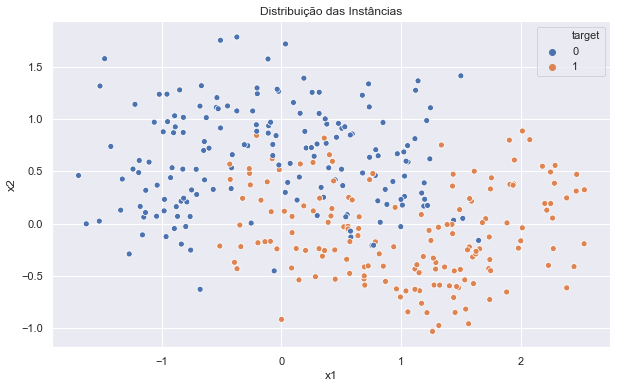

In [34]:
plt.figure(figsize=(10, 6))
plt.title('Distribuição das Instâncias')
plt.xlabel('X1')
plt.ylabel('X2')
sns.scatterplot(data=df_test, x="x1", y="x2", hue="target");

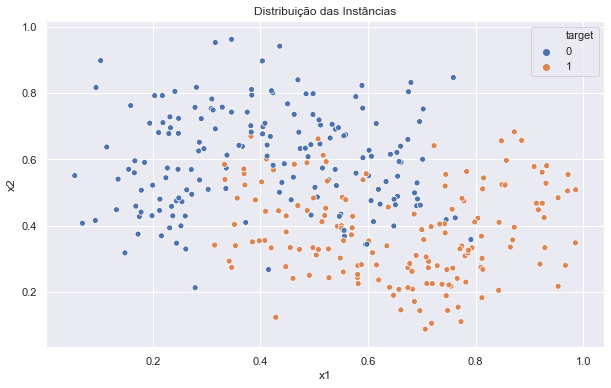

In [35]:
plt.figure(figsize=(10, 6))
plt.title('Distribuição das Instâncias')
plt.xlabel('X1')
plt.ylabel('X2')
sns.scatterplot(data=normalized_test, x="x1", y="x2", hue="target");

Função gerada pelo Regressor Logístico:

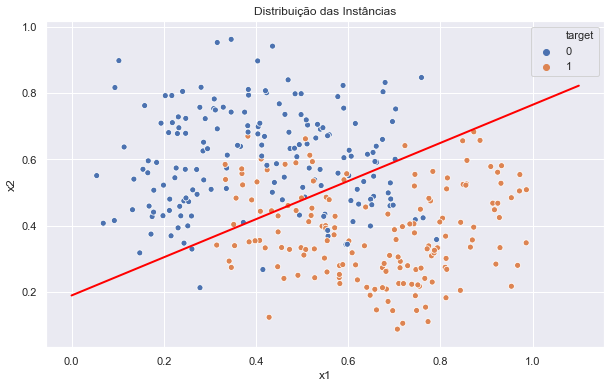

In [36]:
coef = models['Logistic Regression'].coef_
intercept = models['Logistic Regression'].intercept_

x1 = np.linspace(0, 1.1, 100)
x2 = -(x1*(coef[0][0]/coef[0][1])) - ((intercept[0]/coef[0][1]))
plt.figure(figsize=(10, 6))
plt.title('Distribuição das Instâncias')
plt.xlabel('X1')
plt.ylabel('X2')
sns.scatterplot(data=normalized_test, x="x1", y="x2", hue="target");
plt.plot(x1, x2, color='red', linewidth=2);

In [37]:
models

{'Logistic Regression': LogisticRegression(),
 'MLP': MLPClassifier(max_iter=300, random_state=0),
 'Decision Tree': DecisionTreeClassifier(max_depth=16, min_samples_split=128, random_state=0),
 'Random Forest': RandomForestClassifier(max_depth=16, min_samples_split=23, n_estimators=49,
                        random_state=0),
 'KNN': KNeighborsClassifier(n_neighbors=12)}

Calculando os resultados de cada um dos classificadores gerados para os dados de teste:

In [38]:
test_results = {}
conf_matrx = {}
for clf in models:
    y_pred = models[clf].predict(normalized_test[att])
    y_test = normalized_test['target']
    test_results[clf] = {}
    conf_matrx[clf] = confusion_matrix(y_test, y_pred)
    test_results[clf]['accuracy'] = accuracy_score(y_test, y_pred) 
    test_results[clf]['recall'] = recall_score(y_test, y_pred)
    test_results[clf]['precision'] = precision_score(y_test, y_pred)
    test_results[clf]['f1_score'] = f1_score(y_test, y_pred)
    test_results[clf]['f2_score'] = fbeta_score(y_test, y_pred, beta=2)

Comparação das métricas obtidas para o conjunto de teste, nota-se uma boa vantagem para o algoritmo knn em resultados

In [39]:
test_metrics = pd.DataFrame().from_dict(test_results)
test_metrics.style.apply(highlight_max, axis=1)

,Logistic Regression,MLP,Decision Tree,Random Forest,KNN
accuracy,0.836364,0.836364,0.866667,0.872727,0.878788
f1_score,0.834356,0.835366,0.858974,0.871166,0.877301
f2_score,0.840544,0.844636,0.842767,0.877627,0.883807
precision,0.824242,0.820359,0.887417,0.860606,0.866667
recall,0.84472,0.850932,0.832298,0.881988,0.888199


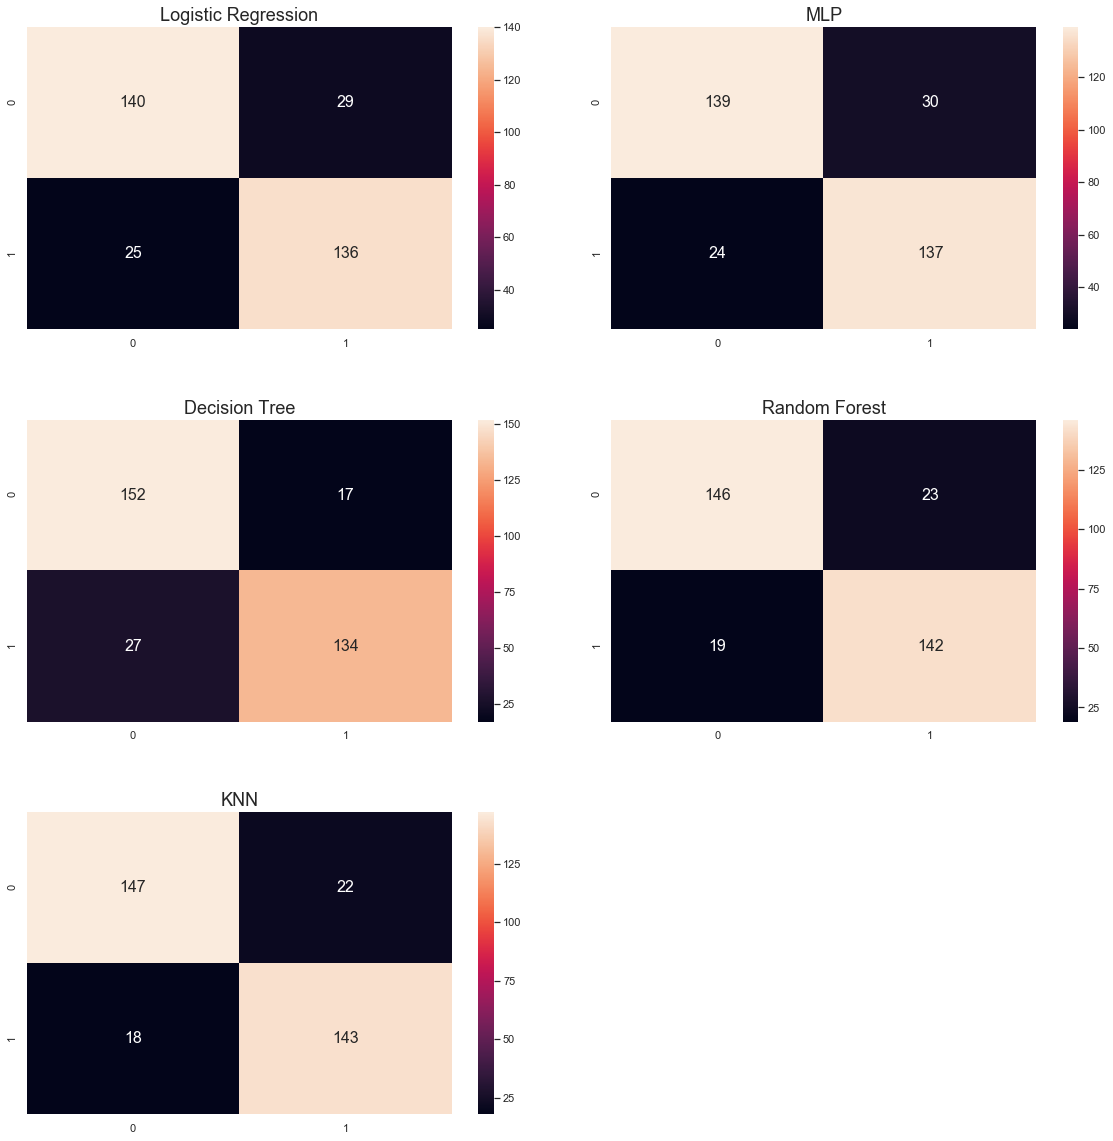

In [40]:
fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
i = 1
for clf in conf_matrx:
    ax = fig.add_subplot(3, 2, i)
    sns.heatmap(conf_matrx[clf], annot=True, fmt="d", annot_kws={'size':16})
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5);
    ax.set_title(clf, fontsize=18)
    i += 1

plt.show()